CQF Final project

"We need to test if time-series are weakly stationary, or integrated of order zero (I(0)), if its statistical properties—specifically its mean, variance, and autocovariance—are invariant with respect to time. The majority of financial price series do not exhibit this property; they are typically non-stationary and contain a unit root, meaning they are integrated of order one (I(1)). A critical issue arises when standard regression techniques are applied to I(1) series. Regressing one I(1) series on another can lead to a "spurious regression," a situation where high R-squared values and statistically significant coefficients are observed even when no genuine economic relationship exists between the variables. This necessitates formal testing for stationarity."

The augmented Dickey–Fuller specification is:

$$
\Delta y_t = \alpha + \beta\,t + \gamma\,y_{t-1}
        + \sum_{i=1}^{p} \delta_i\,\Delta y_{t-i} + \varepsilon_t
$$

The hypotheses are:

- Null hypothesis: $H_0: \gamma = 0$
  (implying a unit root; the series is non-stationary)

- Alternative hypothesis: $H_1: \gamma < 0$
  (implying stationarity)


The Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test statistic for trend‐stationarity is given by

$$
\mathrm{KPSS} \;=\;
\frac{1}{T^2} \sum_{t=1}^T S_t^2 \;\bigg/\; \widehat{\sigma}^2
$$

where

$S_t = \sum_{i=1}^t \widehat{u}_i$

$\widehat{u}_i = y_i - \widehat{\beta}_0 - \widehat{\beta}_1\,i$
are the residuals from the OLS regression of \(y_t\) on an intercept and time trend.  
$(\widehat{\sigma}^2\)$ is a consistent estimate of the long‐run variance of $(\widehat{u}_t\)$, often computed via a Newey–West estimator:
  $$
  \widehat{\sigma}^2
  = \frac{1}{T}\sum_{t=1}^T \widehat{u}_t^2
    \;+\; 2 \sum_{\ell=1}^L w\bigl(\ell,L\bigr)\,
    \frac{1}{T}\sum_{t=\ell+1}^T \widehat{u}_t\,\widehat{u}_{t-\ell},
  $$
  with Bartlett weights \(w(\ell,L)=1-\ell/(L+1)\).

The hypotheses reverse those of the ADF:

- **Null hypothesis** (stationarity around a deterministic trend):  
  $$H_0:\; \{y_t\}\text{ is trend‐stationary}$$

- **Alternative hypothesis** (presence of a unit root):  
  $$H_1:\; \{y_t\}\text{ has a unit root (non‐stationary)}$$

**Interpretation:**  
- A large KPSS statistic leads to rejection of \(H_0\), suggesting non‐stationarity.  
- Used alongside the ADF:  
  - **Fail to reject ADF null** (evidence of unit root) **and** **reject KPSS null** (evidence against stationarity) ⇒ strong confirmation that \(y_t\) is \(I(1)\).


## Statistical Analysis and Threshold Optimization

This section performs the statistical tests and threshold optimization for the downloaded asset groups.

In [1]:
import os
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from data_download import fetch_asset_data
from coint_tests import analyze_error_correction_model, matrix_ols_regression, adf_results, kpss_results, engle_granger, analyze_error_correction_model, ou_params, johansen, kalman_hedge, select_var_order, subsample_cointegration
from pair_selection_summary import assemble_group_summary
from threshold_optimization import optimize_thresholds, plot_threshold_tradeoff
from backtest import nested_cv, generate_signals
from plotting import plot_performance


pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
end_date   = datetime.now()
start_date = end_date - timedelta(days=5*365)

asset_groups = {
    # Commodities
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"], # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                     # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                    # Corn, Soybean Futures

    # Fixed Income & Currency
    "yield_pair": ["^TNX", "IGLT.L"],                 # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],        # AUD/USD, CAD/USD

    # Volatility
    "volatility_pair": ["^VIX", "VIXY"],            # US VIX Index vs. Short-Term VIX Futures ETF*

    # Country Indices
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],           # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],      # IBEX 35, FTSE MIB

    # Equities
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],          # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],       # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],    # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],        # VW, Porsche AG
    "semiconductor_pair": ["ASML.AS", "IFX.DE"],      # ASML, Infineon

    # ETFs
    "sector_etf_pair": ["XLRE", "XLU"]                # Real Estate ETF, Utilities ETF
}

all_data = fetch_asset_data(asset_groups, start_date, end_date)

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%********

In [3]:
records = []
for group, df in all_data.items():
    # Univariate tests
    for col in df.columns:
        records.append({'group': group, 'asset': col, **adf_results(df[col]), **kpss_results(df[col])})

    # Pair vs. Triple logic
    n_assets = len(df.columns)
    if n_assets == 2:
        y, x = df.columns
        # Engle–Granger
        eg = engle_granger(df, y, x)
        records.append({'group': group, 'test': 'Engle-Granger', 'beta': eg['beta'], 'eg_pvalue': eg['eg_pvalue']})

        # Matrix OLS
        X0 = sm.add_constant(df[x])
        mbeta = matrix_ols_regression(df[y].values, X0.values)
        if mbeta is not None:
            records.append({
                'group': group,
                'test': 'Matrix-OLS',
                'const': mbeta[0],
                'slope': mbeta[1]
            })

        # If cointegrated, OU & ECM
        if eg['spread'] is not None:
            ou = ou_params(eg['spread'])
            records.append({'group': group, 'test': 'OU', **ou})

            ecm = analyze_error_correction_model(df[y], df[x], eg['spread'])
            records.append({'group': group, 'test': 'ECM', **ecm})

        # Kalman summary
        kf = kalman_hedge(df, y, x)
        records.append({
            'group': group,
            'test': 'Kalman',
            'kf_beta_mean': kf['kf_beta'].mean()
        })

    elif n_assets == 3:
        # Johansen for triples
        jres = johansen(df)
        records.append({'group': group, 'test': 'Johansen', **jres})

summary_df = pd.DataFrame(records)

/home/gusta/projects/cqf_final_exam/coint_tests.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, _, crit = kpss(series.dropna(), regression='c', nlags='auto')
/home/gusta/projects/cqf_final_exam/coint_tests.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, _, crit = kpss(series.dropna(), regression='c', nlags='auto')
/home/gusta/projects/cqf_final_exam/coint_tests.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, pval, _, crit = kpss(series.dropna(), regression='c', nlags='auto')
/home/gusta/projects/cqf_final_exam/coint_tests.py:38: InterpolationWarning: The test statistic is outside

In [4]:
summary = assemble_group_summary(all_data)

summary

,group,n_assets,eg_pvalue,joh_n_relations,ou_halflife,ou_sigma,sharpe_spread,beta_stability,ecm_pvalue,Z_star,N_trades_Zstar,avg_PnL_Zstar
0,precious_metals_triple,3,NaN,0.00,25.67,1.49,1.36,NaN,NaN,3.00,0.00,NaN
1,oil_pair,2,0.00,NaN,8.35,1.47,1.27,0.02,0.00,0.50,43.00,1.71
2,agri_pair,2,0.01,NaN,36.84,52.20,-1.94,0.10,0.00,1.40,10.00,91.36
3,yield_pair,2,0.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,currency_pair,2,0.02,NaN,40.35,0.02,-14.71,0.06,0.00,0.70,11.00,0.02
5,volatility_pair,2,0.00,NaN,45.39,393.26,-0.94,3.36,0.00,0.80,3.00,721.70
6,eu_index_pair_1,2,0.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,eu_index_pair_2,2,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,fr_banking_pair,2,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,fast_fashion_pair,2,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def analyze_pairs_nb(all_data, selected,
                     Z_min=0.5, Z_max=3.0, dZ=0.1, cost=0.0):
    """
    analysis of selected 2-asset pairs.
    """
    summary = []
    opt_tables = {}

    for pair in selected:
        df = all_data.get(pair)
        if df is None or df.shape[1] != 2:
            print(f"'{pair}': not found or not a 2-asset series.")
            continue

        y_col, x_col = df.columns
        eg = engle_granger(df, y_col, x_col)
        spread, beta = eg['spread'], eg['beta']
        if spread is None:
            print(f"'{pair}' not cointegrated (p={eg['eg_pvalue']:.3f}), skipping.")
            continue

        mu, sigma = spread.mean(), spread.std()
        opt_df = optimize_thresholds(
            spread, mu, sigma, beta,
            y=df[y_col], x=df[x_col],
            Z_min=Z_min, Z_max=Z_max, dZ=dZ, cost=cost
        )
        opt_tables[pair] = opt_df

        # pick best-Z by cum_PnL
        best = opt_df.loc[opt_df['cum_PnL'].idxmax()]
        summary.append({
            'pair':     pair,
            'best_Z':   best['Z'],
            'N_trades': best['N_trades'],
            'cum_PnL':  best['cum_PnL'],
            'avg_PnL':  best['avg_PnL']
        })

        # plot inline
        fig = plot_threshold_tradeoff(opt_df)
        fig.suptitle(f"Tradeoff: {pair}", y=1.02)
        plt.show()

    summary_df = pd.DataFrame(summary)

    return summary_df, opt_tables

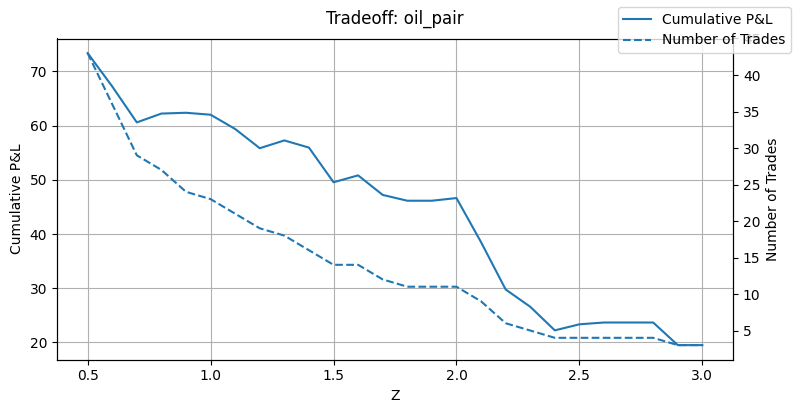

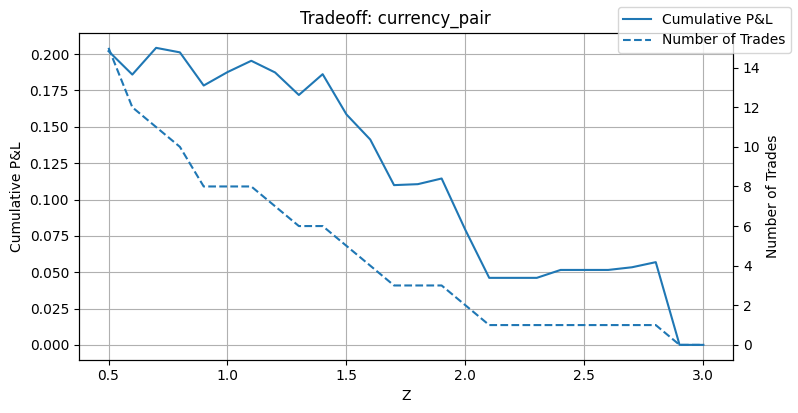

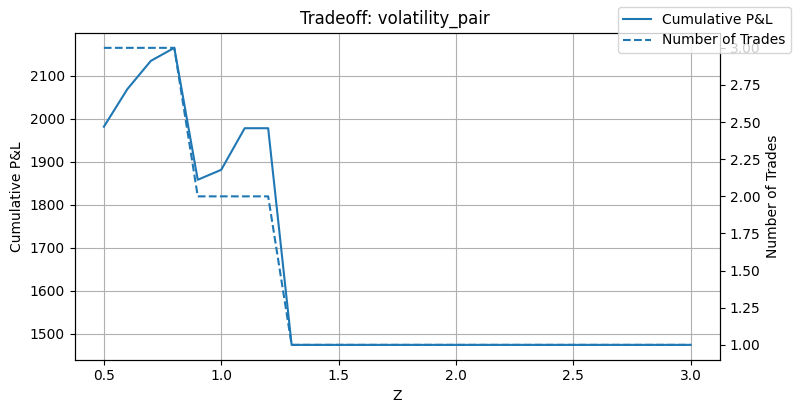

,pair,best_Z,N_trades,cum_PnL,avg_PnL
0,oil_pair,0.50,43.00,73.36,1.71
1,currency_pair,0.70,11.00,0.20,0.02
2,volatility_pair,0.80,3.00,2165.11,721.70


In [6]:
selected = ["oil_pair", "currency_pair", "volatility_pair"]
summary_df, opt_tables = analyze_pairs_nb(
    all_data,
    selected,
    Z_min=0.5,
    Z_max=3.0,
    dZ=0.1,
    cost=0.002
)

# To have JupyterBook render the table below the prints:
summary_df

Oil Pair (WTI vs. Brent): The WTI vs Brent spread csn be driven by physical market factors such regional supply bottlenecks, pipeline outages, and differing quality grades. Also macro drivers like OPEC quotas can impact the supply of WTI/Brent asymetrically. A structural break might occur if pipeline infrastructure is upgraded or if new export policies realign U.S. crude balances which could permanently narrow or widen the spread. Geopolitical events (Libyan civil unrest, U.S. shale booms) can induce regime shifts. These fundamental drivers can pivot the long run equilibrium defined by past price differentials and the signal might then no longer hold.

Currency Pair (AUD/USD vs. CAD/USD) & Volatility Pair (VIX vs. VIXY): The AUD–CAD cross owes its co movement to both being commodity currencies, but central bank divergence e.g. the RBA cutting rates sharply while the BoC remains hawkish can decouple their rates and break the historical cointegration. For VIX vs VIXY structural breaks arise when futures curve dynamics change, a systemic shift in collateral demand or a persistent volatility regime (e.g. prolonged low volatility or crisis spikes) can alter the term structure roll yield that VIXY captures. In both cases, a shifting monetary policy stance or a regime change in risk aversion can turn the once stationary spread into a drifting series.

In [7]:
results = {}

for pair in selected:
    df = all_data[pair]                     # DataFrame of raw prices
    y, x = df.columns
    
    # 3a. Run Engle–Granger to get the stationary spread
    eg = engle_granger(df, y, x)
    spread = eg['spread'].dropna()
    
    # 3b. Compute μ_e and σ_eq via your OU helper
    ou = ou_params(spread)
    mu_e     = ou['ou_mu']
    sigma_eq = ou['ou_sigma']
    
    # 3c. Build a minimal DataFrame for backtesting
    df_pair = pd.DataFrame({'spread': spread})
    
    # 3d. Run nested CV
    cv_df = nested_cv(
        df_pair,
        spread_col='spread',
        mu_e=mu_e,
        sigma_eq=sigma_eq,
        z_list=[0.5, 1.0, 1.5, 2.0],
        train_months=18,
        test_months=6,
        step_months=3
    )
    
    results[pair] = cv_df

# 4. Inspect results
for pair, df_cv in results.items():
    print(f"\n=== CV results for {pair} ===")
    display(df_cv)


=== CV results for oil_pair ===


/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))


,train_start,train_end,test_start,test_end,best_z,train_sharpe,test_sharpe,test_max_drawdown,test_turnover,test_hit_ratio
0,2020-07-21,2022-01-21,2022-01-21,2022-07-21,0.50,1.65,3.22,-3.79,0.19,0.57
1,2020-10-21,2022-04-21,2022-04-21,2022-10-21,1.00,2.08,2.39,-3.82,0.20,0.52
2,2021-01-21,2022-07-21,2022-07-21,2023-01-21,0.50,2.02,0.48,-3.86,0.03,0.49
3,2021-04-21,2022-10-21,2022-10-21,2023-04-21,0.50,1.85,1.94,-2.46,0.04,0.52
4,2021-07-21,2023-01-21,2023-01-21,2023-07-21,0.50,1.78,2.34,-1.38,0.09,0.54
5,2021-10-21,2023-04-21,2023-04-21,2023-10-21,1.00,1.70,2.25,-0.21,0.03,0.60
6,2022-01-21,2023-07-21,2023-07-21,2024-01-21,0.50,1.75,1.67,-2.00,0.13,0.51
7,2022-04-21,2023-10-21,2023-10-21,2024-04-21,0.50,1.83,1.13,-2.00,0.10,0.48
8,2022-07-21,2024-01-21,2024-01-21,2024-07-21,0.50,1.71,2.16,-0.91,0.15,0.55
9,2022-10-21,2024-04-21,2024-04-21,2024-10-21,0.50,1.67,2.95,-0.91,0.16,0.65



=== CV results for currency_pair ===


,train_start,train_end,test_start,test_end,best_z,train_sharpe,test_sharpe,test_max_drawdown,test_turnover,test_hit_ratio
0,2020-07-21,2022-01-21,2022-01-21,2022-07-21,1.00,1.39,1.20,-0.01,0.11,0.46
1,2020-10-21,2022-04-21,2022-04-21,2022-10-21,1.00,1.25,2.26,-0.01,0.15,0.51
2,2021-01-21,2022-07-21,2022-07-21,2023-01-21,1.00,1.26,4.00,-0.00,0.14,0.61
3,2021-04-21,2022-10-21,2022-10-21,2023-04-21,1.00,1.37,2.20,-0.01,0.10,0.54
4,2021-07-21,2023-01-21,2023-01-21,2023-07-21,1.00,1.33,1.40,-0.01,0.07,0.56
5,2021-10-21,2023-04-21,2023-04-21,2023-10-21,1.00,1.40,0.86,-0.02,0.07,0.51
6,2022-01-21,2023-07-21,2023-07-21,2024-01-21,1.00,1.40,1.10,-0.02,0.06,0.49
7,2022-04-21,2023-10-21,2023-10-21,2024-04-21,1.00,1.42,2.40,-0.00,0.07,0.71
8,2022-07-21,2024-01-21,2024-01-21,2024-07-21,1.00,1.42,1.23,-0.00,0.05,0.64
9,2022-10-21,2024-04-21,2024-04-21,2024-10-21,1.00,1.37,1.49,-0.00,0.05,0.43



=== CV results for volatility_pair ===


,train_start,train_end,test_start,test_end,best_z,train_sharpe,test_sharpe,test_max_drawdown,test_turnover,test_hit_ratio
0,2020-07-21,2022-01-21,2022-01-21,2022-07-21,1.50,1.18,NaN,0.00,0.00,0.00
1,2020-10-21,2022-04-21,2022-04-21,2022-10-21,1.50,1.18,NaN,0.00,0.00,0.00
2,2021-01-21,2022-07-21,2022-07-21,2023-01-21,1.50,1.18,NaN,0.00,0.00,0.00
3,2021-04-21,2022-10-21,2022-10-21,2023-04-21,1.50,1.18,NaN,0.00,0.00,0.00
4,2021-07-21,2023-01-21,2023-01-21,2023-07-21,0.50,1.20,1.39,-72.85,0.03,0.57
5,2021-10-21,2023-04-21,2023-04-21,2023-10-21,0.50,1.24,-1.41,-10.54,0.01,0.00
6,2022-01-21,2023-07-21,2023-07-21,2024-01-21,0.50,1.23,1.32,-18.25,0.03,0.40
7,2022-04-21,2023-10-21,2023-10-21,2024-04-21,0.50,1.23,0.83,-18.25,0.02,0.33
8,2022-07-21,2024-01-21,2024-01-21,2024-07-21,0.50,1.25,NaN,0.00,0.00,0.00
9,2022-10-21,2024-04-21,2024-04-21,2024-10-21,0.50,1.29,0.59,-530.46,0.06,0.62


In [8]:
# --- Rerun nested CV for volatility_pair only ---

pair = 'volatility_pair'
df = all_data[pair]                     # DataFrame of raw prices
y, x = df.columns

# 1. Engle–Granger → stationary spread
eg = engle_granger(df, y, x)
spread = eg['spread'].dropna()

# 2. OU params → μ_e and σ_eq
ou = ou_params(spread)
mu_e     = ou['ou_mu']
sigma_eq = ou['ou_sigma']

# 3. Build spread DataFrame
df_pair = pd.DataFrame({'spread': spread})

# 4. Use a wider Z‐grid so we actually get trades
z_list = [1.5, 2.0, 2.5, 3.0]

# 5. Run nested CV
cv_df = nested_cv(
    df_pair,
    spread_col='spread',
    mu_e=mu_e,
    sigma_eq=sigma_eq,
    z_list=z_list,
    train_months=18,
    test_months=6,
    step_months=3
)

# 6. Drop folds with no trades or undefined Sharpe
cv_df = cv_df.dropna(subset=['test_sharpe'])
cv_df = cv_df[cv_df['test_turnover'] > 0]

# 7. Display the results
print("=== Filtered CV results for volatility_pair ===")
display(cv_df)


=== Filtered CV results for volatility_pair ===


/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret.mean() * 252) / (ret.std() * np.sqrt(252))
/home/gusta/projects/cqf_final_exam/backtest.py:67: RuntimeWarning: invalid value encountered in scalar divide
  ann_sharpe = (ret

,train_start,train_end,test_start,test_end,best_z,train_sharpe,test_sharpe,test_max_drawdown,test_turnover,test_hit_ratio
9,2022-10-21,2024-04-21,2024-04-21,2024-10-21,1.50,1.08,1.42,0.00,0.02,0.50
10,2023-01-21,2024-07-21,2024-07-21,2025-01-21,1.50,1.08,1.43,0.00,0.02,0.50
11,2023-04-21,2024-10-21,2024-10-21,2025-04-21,1.50,1.30,1.19,-248.16,0.03,0.56


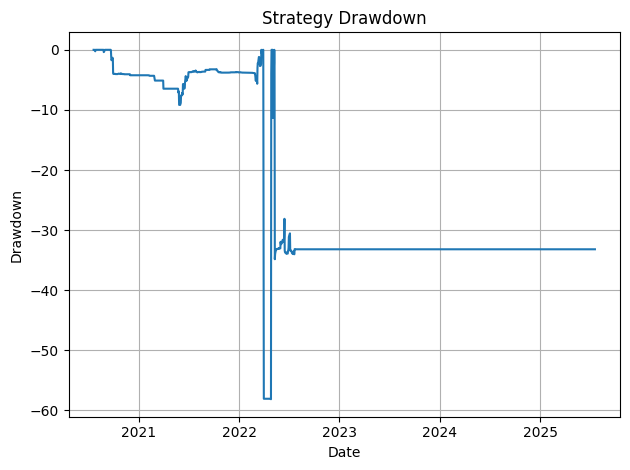

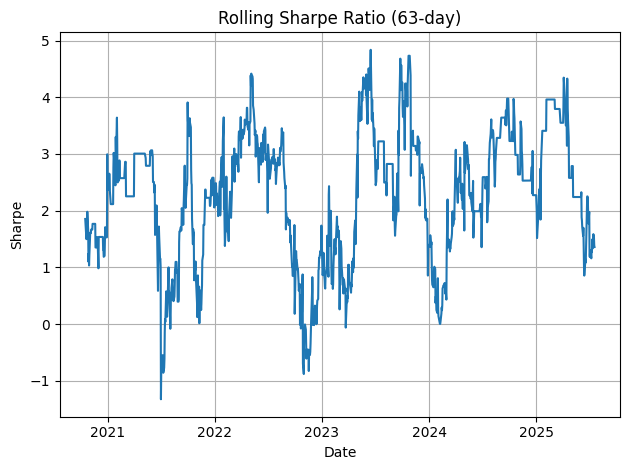

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


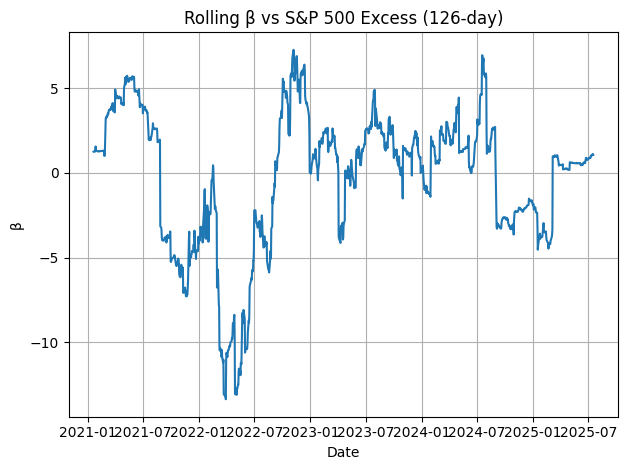

In [10]:
pnl = {}

for pair in selected:
    # 1. Recompute the spread
    df   = all_data[pair]
    y,x  = df.columns
    eg   = engle_granger(df, y, x)
    spread = eg['spread'].dropna()

    # 2. Get the optimal Z from your summary_df
    best_Z = summary_df.loc[summary_df['pair']==pair, 'best_Z'].iloc[0]

    # 3. Build the signal on that spread
    mu, sigma = spread.mean(), spread.std()
    sig = generate_signals(spread, mu, sigma, best_Z)

    # 4. Daily returns = position_{t-1} * Δspread_t
    ret = sig.shift(1) * spread.diff()

    # 5. Cumulative PnL
    pnl[pair] = ret.cumsum()

# Now for example:
vol_pnl = pnl['oil_pair']

# Convert to returns and plot
strat_ret = vol_pnl.diff().fillna(0)
plot_performance(strat_ret)